In [1]:
# Код спайковой нейросети для удаления шума из изображения с помощью автоэнкодера из этого примера
# https://github.com/msurtsukov/ae_vae_gan/blob/master/autoencoders_1.ipynb

In [2]:
%matplotlib inline

from urllib.request import urlretrieve
import keras_spiking
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
from nengo_dl.graph_optimizer import noop_planner
import nengo_dl
import cv2
import keras.backend as K
import imageio.v2 as imageio

seed = 0
tf.random.set_seed(seed)

2024-06-24 21:02:59.326149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 21:02:59.533665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-24 21:02:59.533727: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-24 21:03:01.077580: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

train_images = train_images.reshape((train_images.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1)) 

# Функция для добавления гауссовского шума
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    # Нормализация изображений, чтобы значения оставались в пределах [0, 1]
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

train_noised_images = add_gaussian_noise(train_images)
test_noised_images = add_gaussian_noise(test_images)

In [4]:
# Модель VAE
encoding_dim = 49
batch_size = 500
input_img = tf.keras.Input(shape=(28, 28, 1), batch_size=batch_size) 
flat_img = tf.keras.layers.Flatten()(input_img)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(flat_img)

input_encoded = tf.keras.Input(shape=(encoding_dim,))
flat_decoded = tf.keras.layers.Dense(28*28, activation='sigmoid')(input_encoded)
decoded = tf.keras.layers.Reshape((28, 28, 1))(flat_decoded)

encoder =  tf.keras.Model(input_img, encoded, name="encoder")
decoder =  tf.keras.Model(input_encoded, decoded, name="decoder")
autoencoder =  tf.keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.summary()

2024-06-24 21:03:13.659416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/buligar/miniforge3/envs/nest/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-24 21:03:13.659520: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-24 21:03:13.659563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (buligar): /proc/driver/nvidia/version does not exist
2024-06-24 21:03:13.665400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(500, 28, 28, 1)]        0         
                                                                 
 encoder (Functional)        (500, 49)                 38465     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Конвертация модели в спайковую
print(autoencoder.output)
energy = keras_spiking.ModelEnergy(autoencoder)
energy.summary(print_warnings=False)
converter = nengo_dl.Converter(autoencoder)

KerasTensor(type_spec=TensorSpec(shape=(500, 28, 28, 1), dtype=tf.float32, name=None), name='decoder/reshape/Reshape:0', description="created by layer 'decoder'")
Layer (type)        |Output shape      |Param #|Conn #|Neuron #|J/inf (cpu)
--------------------|------------------|-------|------|--------|-----------
input_1 (InputLayer)|[(500, 28, 28, 1)]|      0|     0|       0|          0
encoder (Functional)|         (500, 49)|  38465|     0|       0|          0
decoder (Functional)| (None, 28, 28, 1)|  39200|     0|       0|          0
Total energy per inference [Joules/inf] (cpu): 0.00e+00


/home/buligar/miniforge3/envs/nest/lib/python3.10/site-packages/keras_spiking/model_energy.py:773: UserWarning: Cannot compute stats for layer of type 'Functional'.Use `ModelEnergy.register_layer` to register this layer.
  warnings.warn(


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00

/home/buligar/miniforge3/envs/nest/lib/python3.10/site-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Construction finished in 0:00:00                                               


2024-06-24 21:03:14.983061: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2024-06-24 21:03:15.034100: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
300/300 [==============================] - 8s 17ms/step - loss: 0.0836 - probe_loss: 0.0836 - probe_mean_squared_error: 0.0836
Epoch 2/10
300/300 [==============================] - 5s 15ms/step - loss: 0.0577 - probe_loss: 0.0577 - probe_mean_squared_error: 0.0577
Epoch 3/10
300/300 [==============================] - 4s 14ms/step - loss: 0.0468 - probe_loss: 0.0468 - probe_mean_squared_error: 0.0468
Epoch 4/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0406 - probe_loss: 0.0406 - probe_mean_squared_error: 0.0406
Epoch 5/10
300/300 [==============================] - 5s 18ms/step - loss: 0.0367 - probe_loss: 0.0367 - probe_mean_squared_error: 0.0367
Epoch 6/10
300/300 [==============================] - 7s 24ms/step - loss: 0.0337 - probe_loss: 0.0337 - probe_mean_squared_error: 0.0337
Epoch 7/10
300/300 [==============================] - 6s 20ms/step - loss: 0.0311 - probe_loss: 0.0311 - probe_mean_squared_error: 0.0311
Epoch 8/10
300/300 [==============

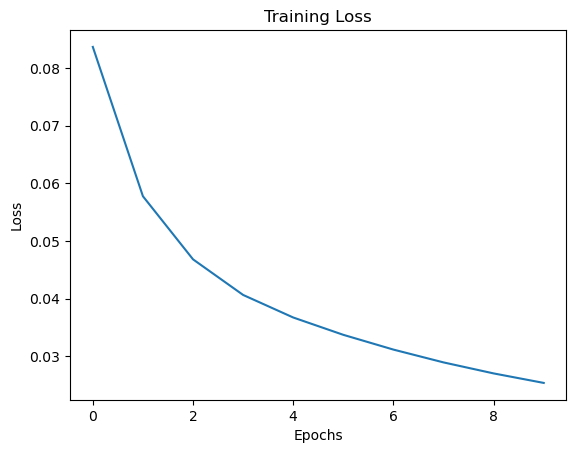

In [6]:

with converter.net:
      nengo_dl.configure_settings(planner=noop_planner)
    
# Сборка и обучение модели 
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={converter.outputs[autoencoder.output]: tf.losses.MeanSquaredError()},
        metrics={converter.outputs[autoencoder.output]: tf.metrics.MeanSquaredError()}
    )
    history = sim.fit(
        {converter.inputs[input_img]: train_noised_images},
        {converter.outputs[autoencoder.output]: train_images},
        epochs=10
    )
   
    # Вывод истории обучения
    plt.plot(history.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    # Сохранение параметров
    sim.save_params("./keras_to_snn_params")

In [7]:
# запуск модели 
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_test=500, # 500 тестовых изображений
    n_steps=120, # Время подачи одного изображения
    synapse=None,

):
    nengo_converter = nengo_dl.Converter(
        autoencoder,
        swap_activations={tf.nn.relu: activation},
        synapse=synapse,
    )
    
    nengo_input = nengo_converter.inputs[input_img]
    nengo_output = nengo_converter.outputs[autoencoder.output]

    with nengo_converter.net:
        nengo_dl.configure_settings(planner=noop_planner)
        
    tiled_test_images = np.tile(test_noised_images[:n_test], (1, n_steps, 1))
    # Загрузка параметров и предсказание модели 
    with nengo_dl.Simulator(nengo_converter.net, minibatch_size=10, progress_bar=False) as nengo_sim:
        nengo_sim.load_params(params_file)  
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Noised image")
        plt.imshow(test_noised_images[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.imshow(data[nengo_output][ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.tight_layout()
        
    gif_images = []
    for timestep in range(n_steps):
        plt.figure(figsize=(4, 4))
        plt.imshow(data[nengo_output][0, timestep].reshape((28, 28)), cmap="gray")
        plt.axis("off")
        plt.title(f"Output at timestep {timestep}")
        filename = f"output_timestep_{timestep:03d}.png"
        plt.savefig(filename)
        plt.close()
        gif_images.append(filename)
    
    # Create GIF from images
    images = [imageio.imread(img) for img in gif_images]
    imageio.mimsave('output_animation.gif', images, duration=0.1)

/home/buligar/miniforge3/envs/nest/lib/python3.10/site-packages/nengo_dl/converter.py:140: UserWarning: swap_activations contained {<function relu at 0x7fe0bf990d30>}, but there were no layers in the model with that activation type
  warnings.warn(
2024-06-24 21:04:33.766590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


50/50 [==============================] - 12s 201ms/step


2024-06-24 21:04:52.080415: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


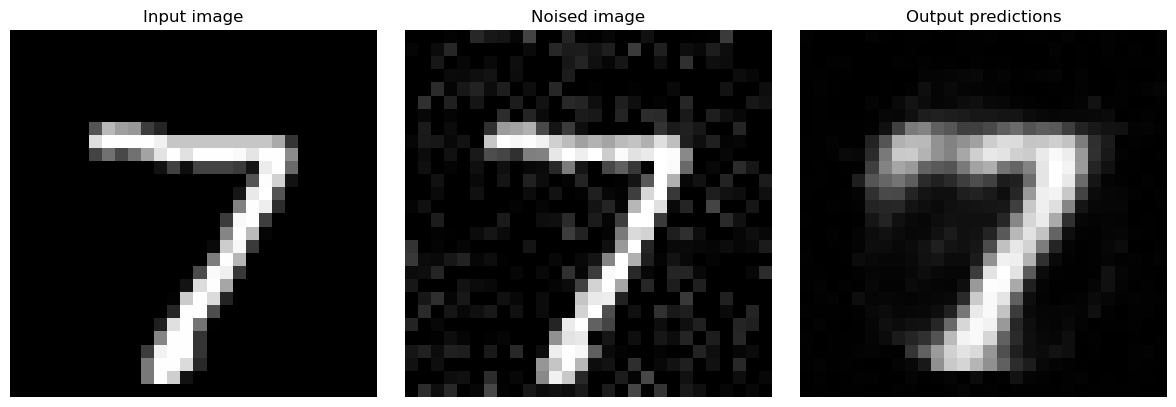

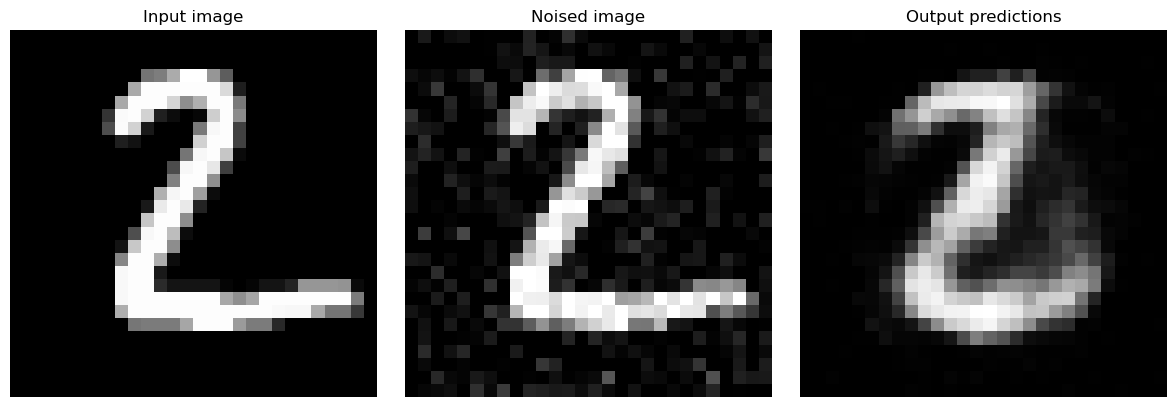

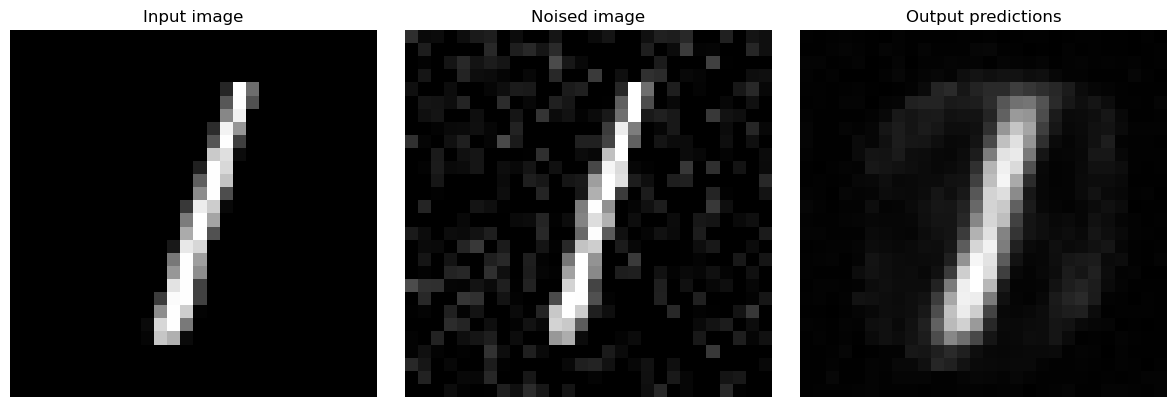

In [8]:
run_network(activation=nengo.RectifiedLinear())